In [2]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

In [3]:
asset_path = 'projects/gee-training-467008/assets/Antragsdaten_2025_Mecklenburgische-Seenplatte_FB_alap_merged_32633'
fc = ee.FeatureCollection(asset_path)
aoi = fc.geometry().bounds()

params = {
    'year': 2025,
    'scale': 10,
    'crs': 'EPSG:32633',
    'start': '2025-01-01',
    'end': '2025-12-31'
}

In [4]:
def get_s2_clean_data(aoi, start, end):
    
    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
          .filterBounds(aoi)
          .filterDate(start, end))

    cs_plus = (ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')
               .filterBounds(aoi)
               .filterDate(start, end))

    join = ee.Join.saveFirst(matchKey='cs_img')
    filter_join = ee.Filter.equals(leftField='system:index', rightField='system:index')
    
    joined_col = ee.ImageCollection(join.apply(s2, cs_plus, filter_join))

    def process_image(img):
        cs_img = ee.Image(img.get('cs_img'))
        mask = cs_img.select('cs').gte(0.6)
        
        ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
        ndmi = img.normalizedDifference(['B8', 'B11']).rename('NDMI')
        ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')
        msi = img.select('B11').divide(img.select('B8')).rename('MSI')

        return img.updateMask(mask).addBands([ndwi, ndmi, ndvi, msi])

    return joined_col.map(process_image)

def get_s1_clean_data(aoi, start, end):
    
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterBounds(aoi)
          .filterDate(start, end)
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
          .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING')))

    def add_indices(img):
        vv_linear = ee.Image(10).pow(img.select('VV').divide(10))
        vh_linear = ee.Image(10).pow(img.select('VH').divide(10))
        
        rvi = vh_linear.multiply(4).divide(vv_linear.add(vh_linear)).rename('RVI')
        
        cp_ratio = vh_linear.divide(vv_linear).rename('VH_VV_ratio')

        return img.addBands([rvi, cp_ratio])

    return s1.map(add_indices)

In [5]:
def process_monthly_stats(feature_collection):
    
    s2_col = get_s2_clean_data(aoi, params['start'], params['end'])
    s1_col = get_s1_clean_data(aoi, params['start'], params['end'])

    months = ee.List.sequence(1, 12)

    def process_month(m):
        m = ee.Number(m)
        
        s2_month = s2_col.filter(ee.Filter.calendarRange(m, m, 'month')).median()
        s1_month = s1_col.filter(ee.Filter.calendarRange(m, m, 'month')).median()
        
        combined = s2_month.addBands(s1_month)
        
        combined = combined.set('month', m).set('year', params['year'])
        
        bands_to_use = ['NDWI', 'NDMI', 'NDVI', 'MSI', 'VV', 'VH', 'RVI']
        combined = combined.select(bands_to_use)
        
        stats = combined.reduceRegions(
            collection = feature_collection,
            reducer = ee.Reducer.mean(), 
            scale = params['scale'],
            crs = params['crs']
        )
        
        return stats.map(lambda f: f.set('month', m).set('year', params['year']))

    monthly_stats_list = months.map(process_month)
    flat_collection = ee.FeatureCollection(monthly_stats_list).flatten()
    
    return flat_collection.filter(ee.Filter.notNull(['NDWI']))

In [6]:
final_stats = process_monthly_stats(fc)

export_cols = ['month', 'year', 'öko', 'nc', 'NDWI', 'NDMI', 'NDVI', 'MSI', 'VV', 'VH', 'RVI']

task = ee.batch.Export.table.toDrive(
    collection=final_stats,
    description='mecklenburg_2025_analysis_new',
    folder='GEE_Exports_MV',
    fileFormat='CSV',
    selectors=export_cols
)

task.start()

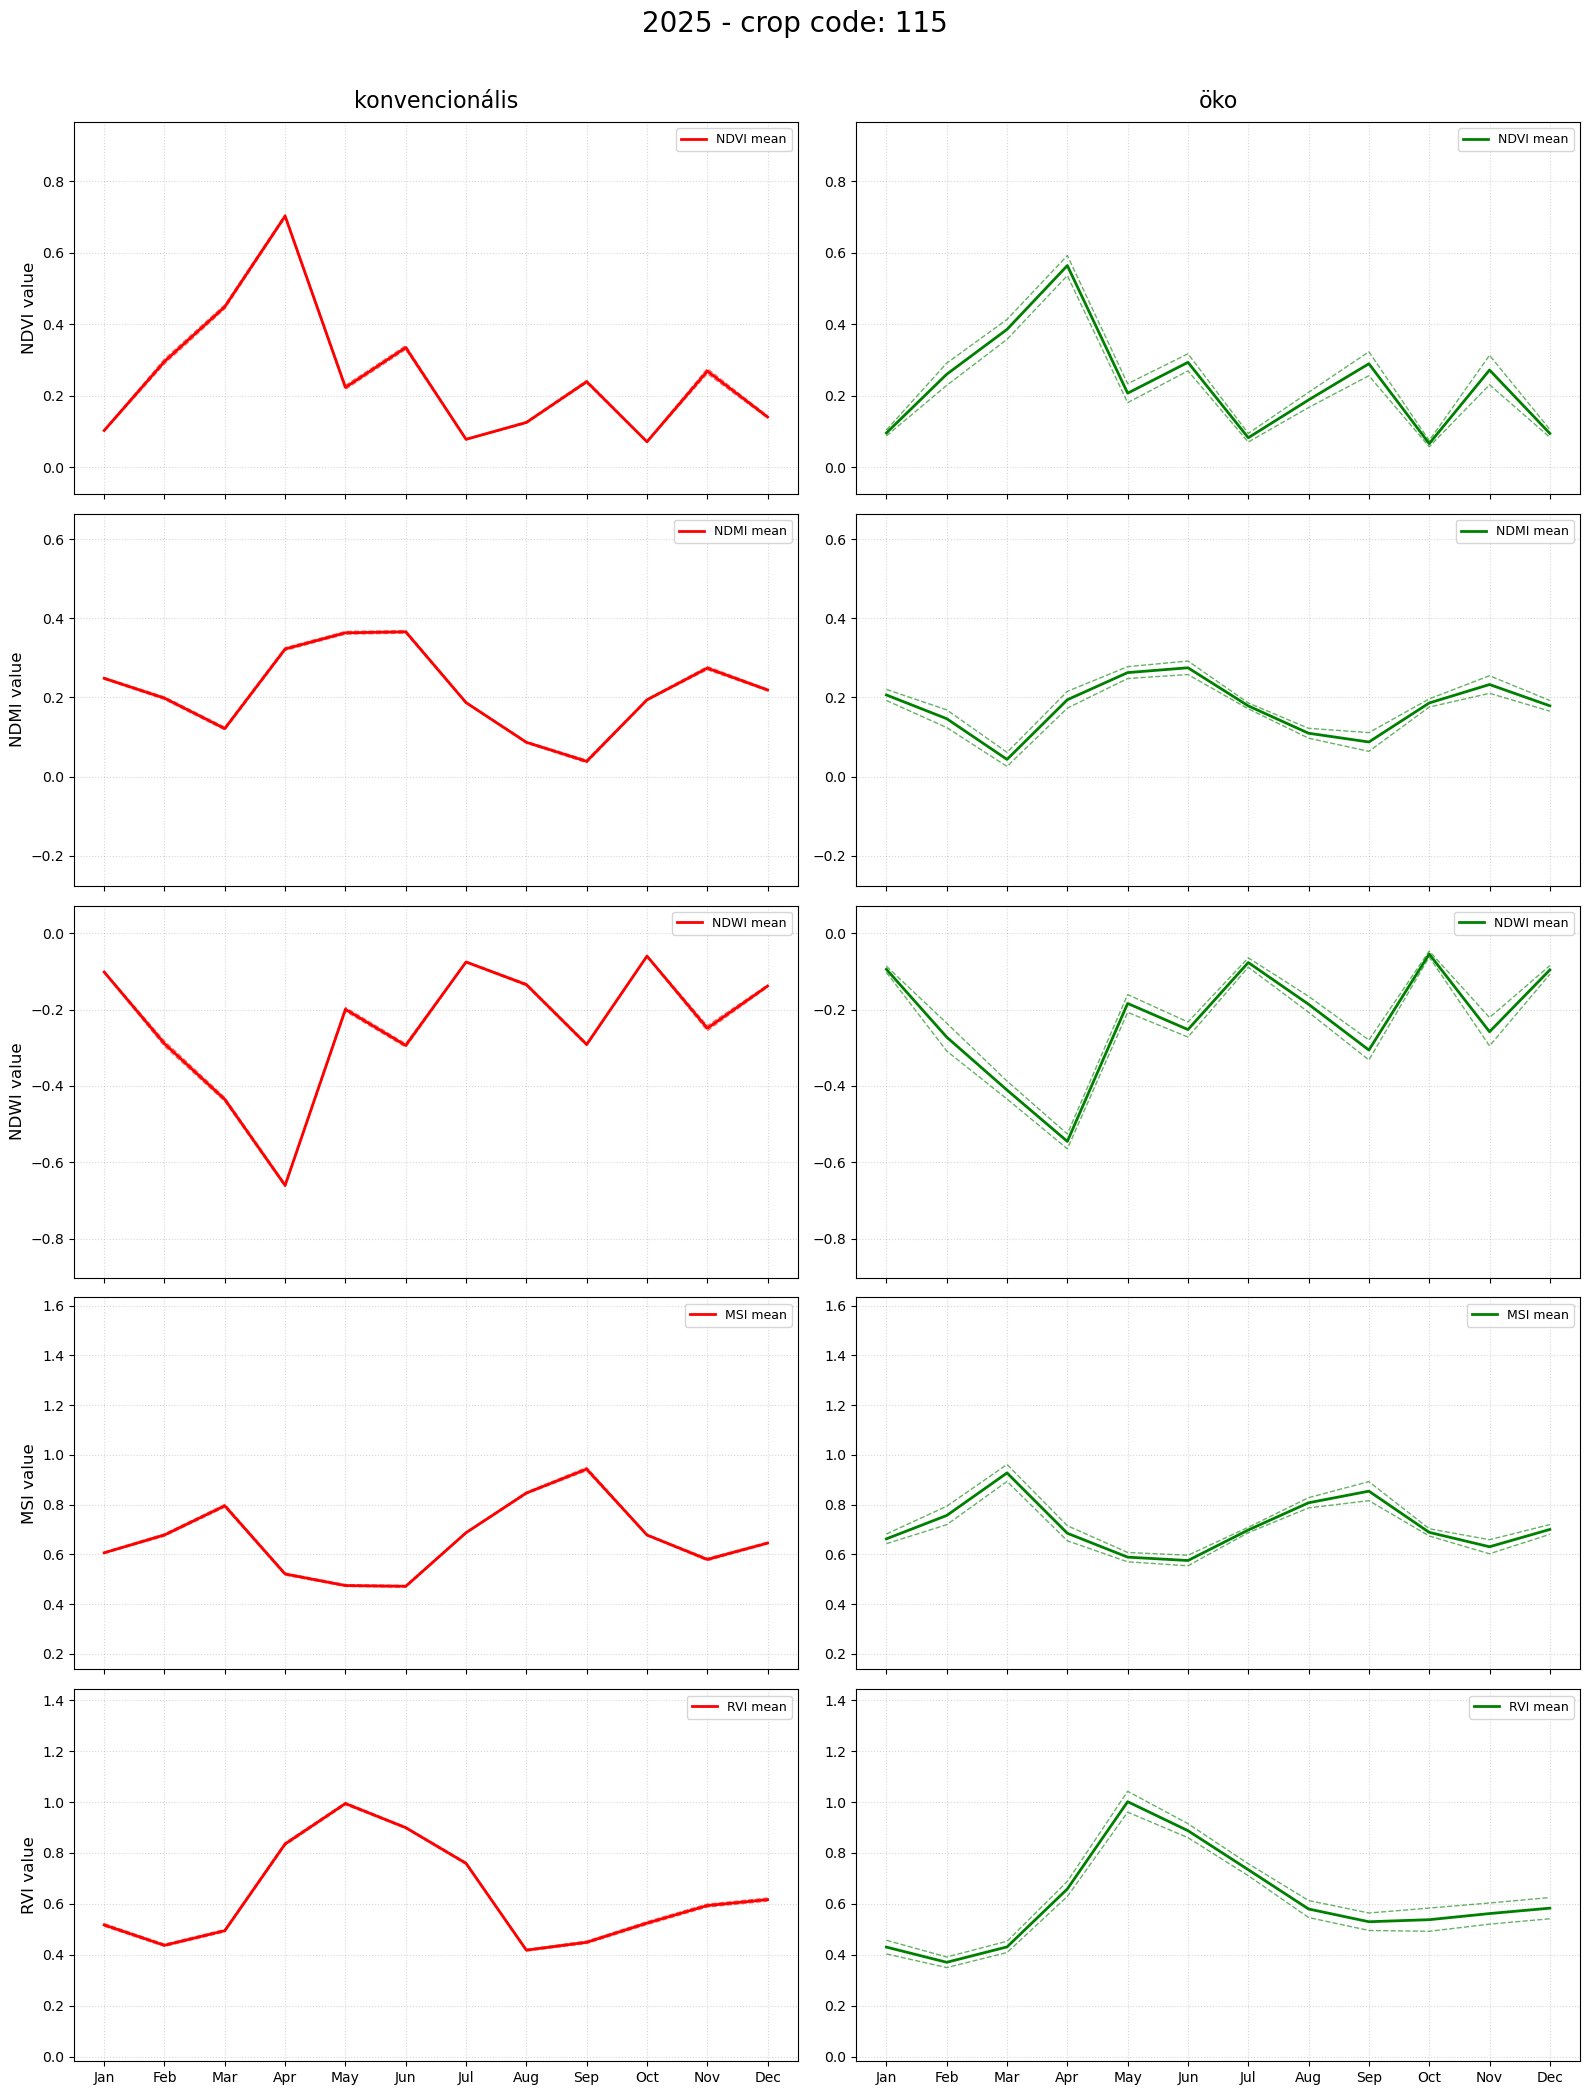

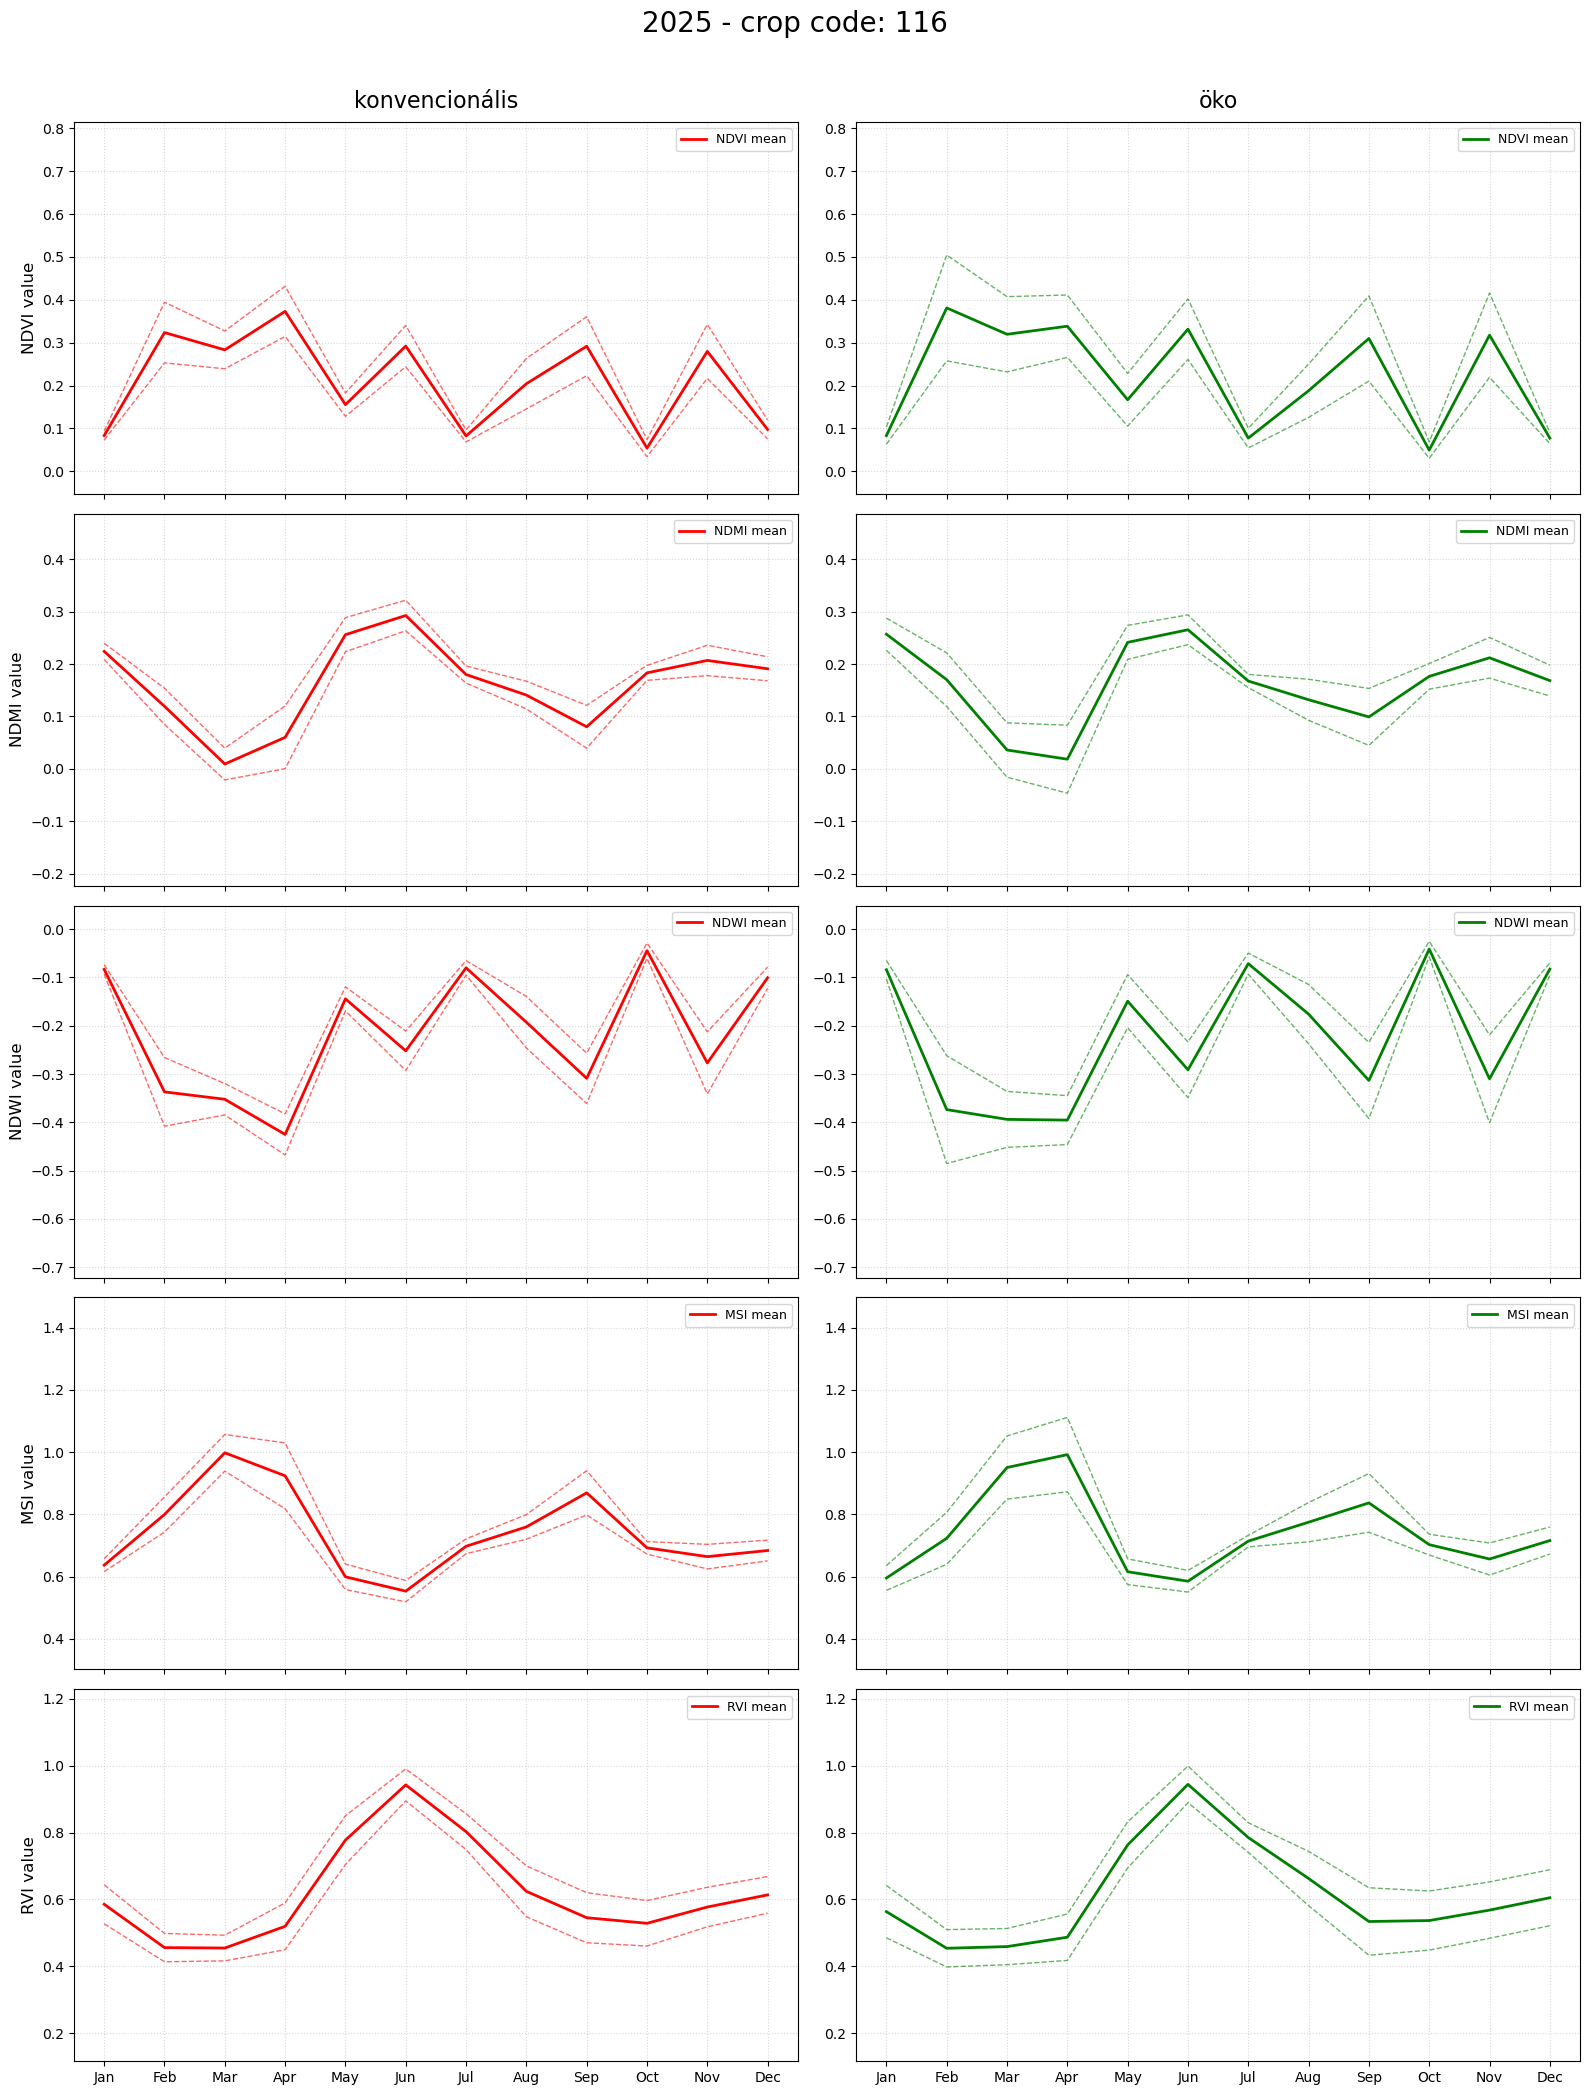

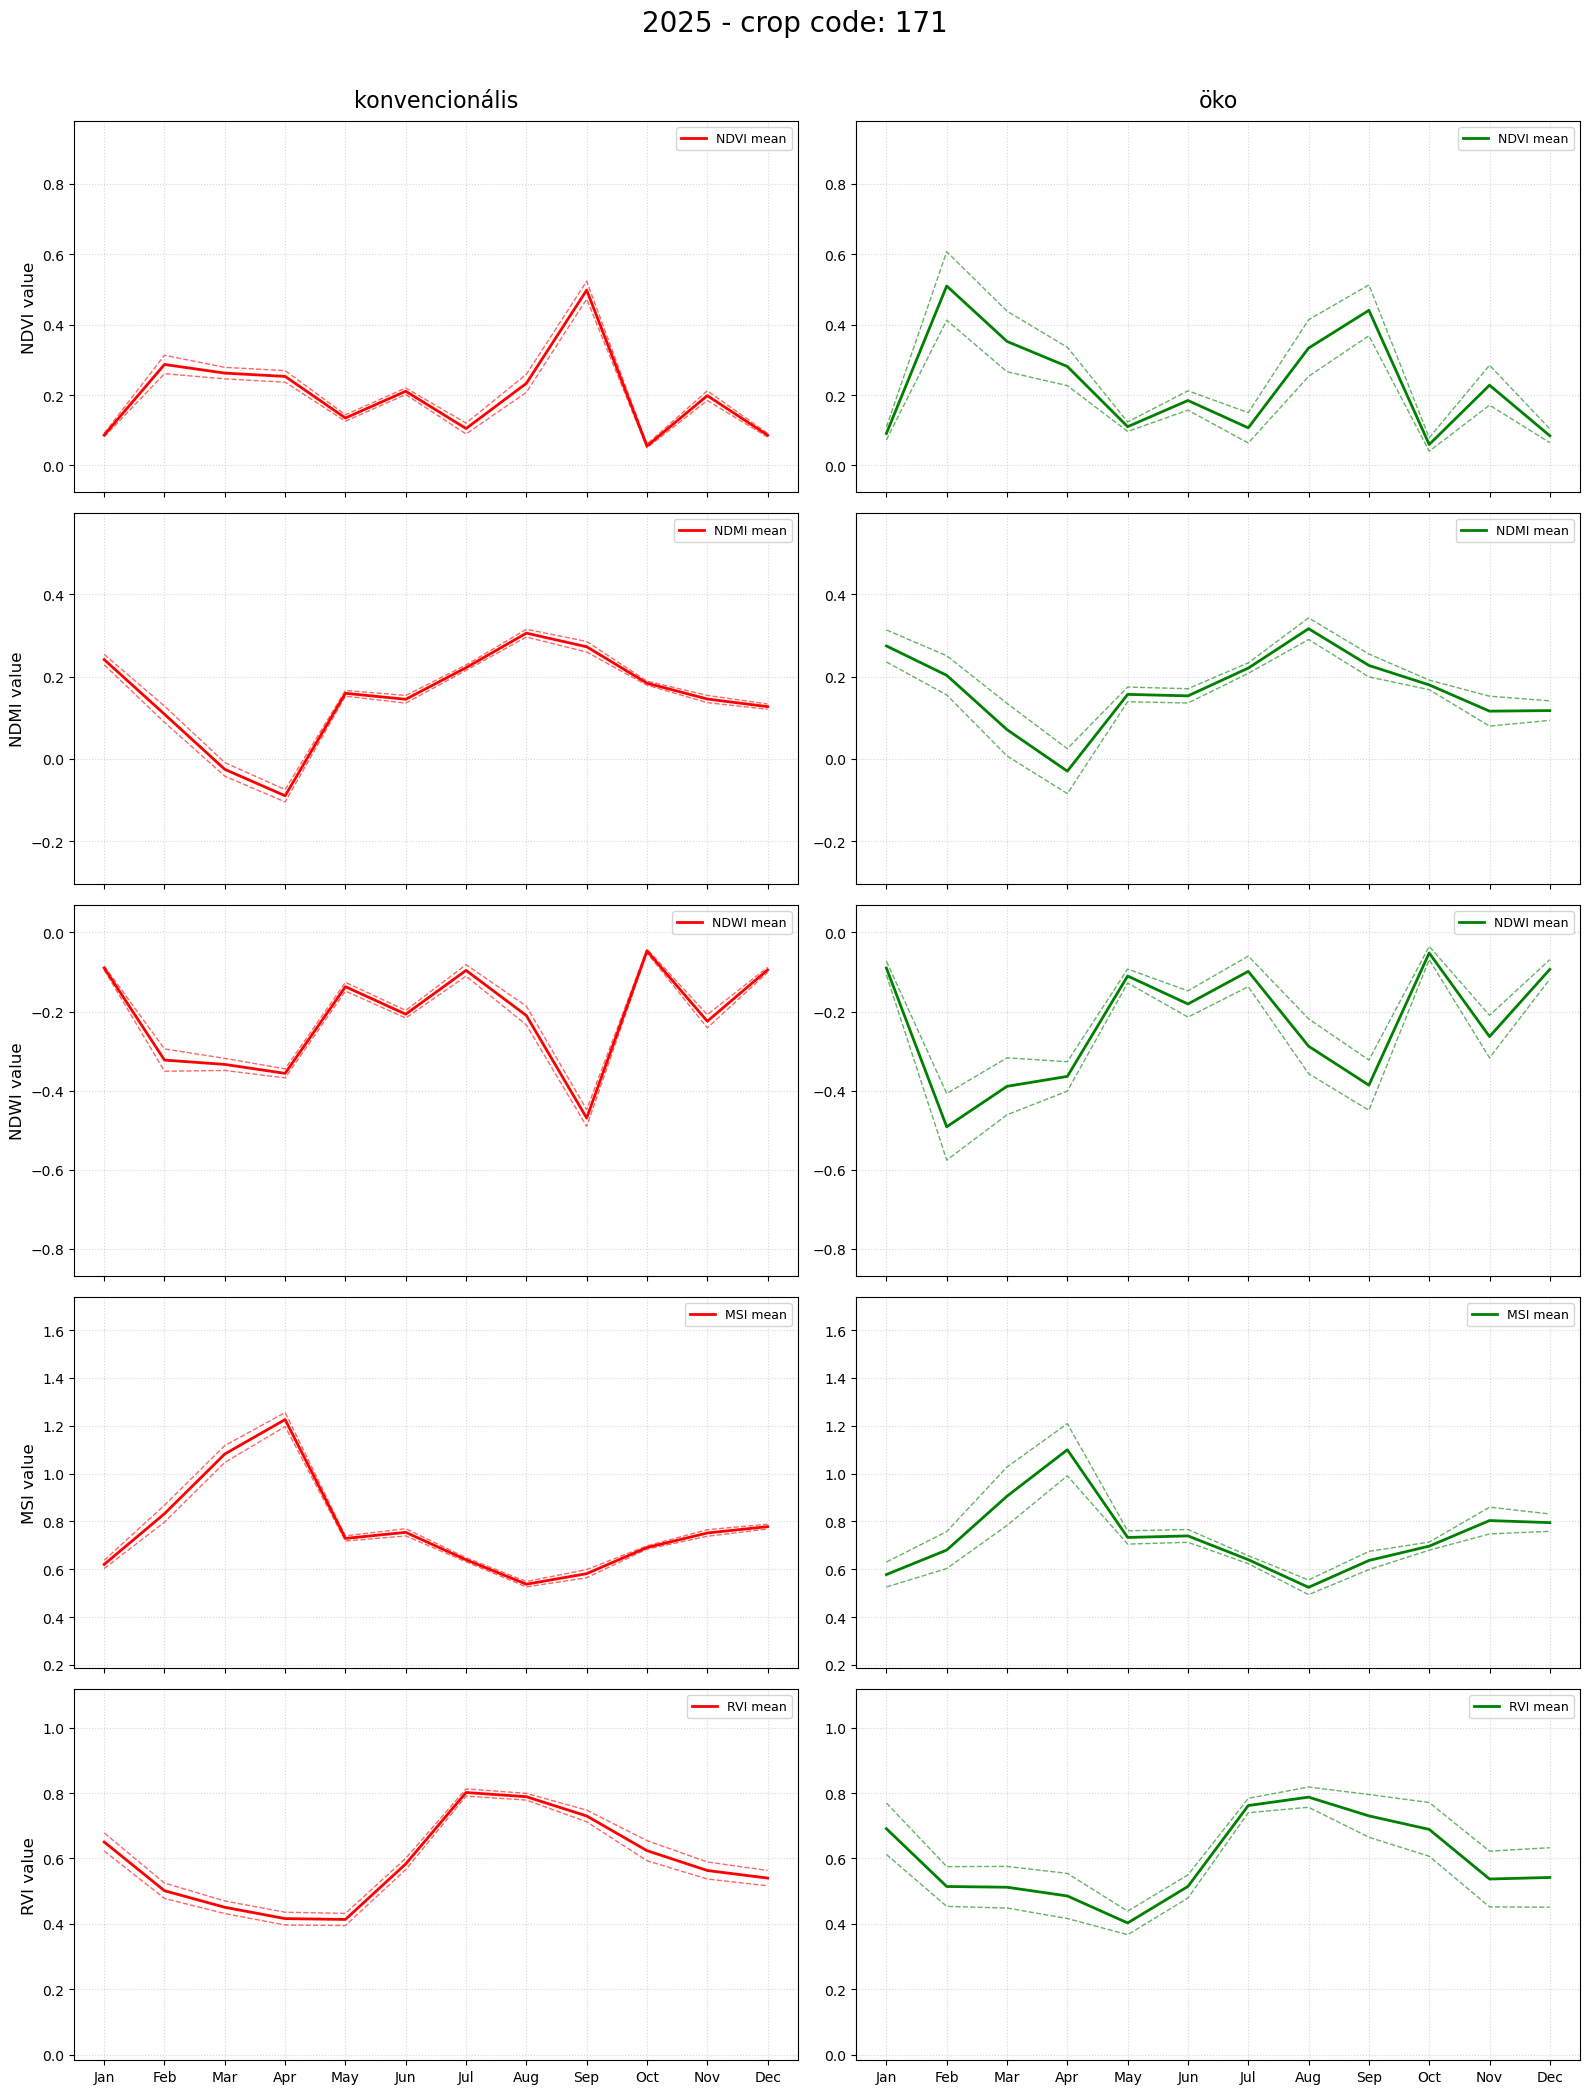

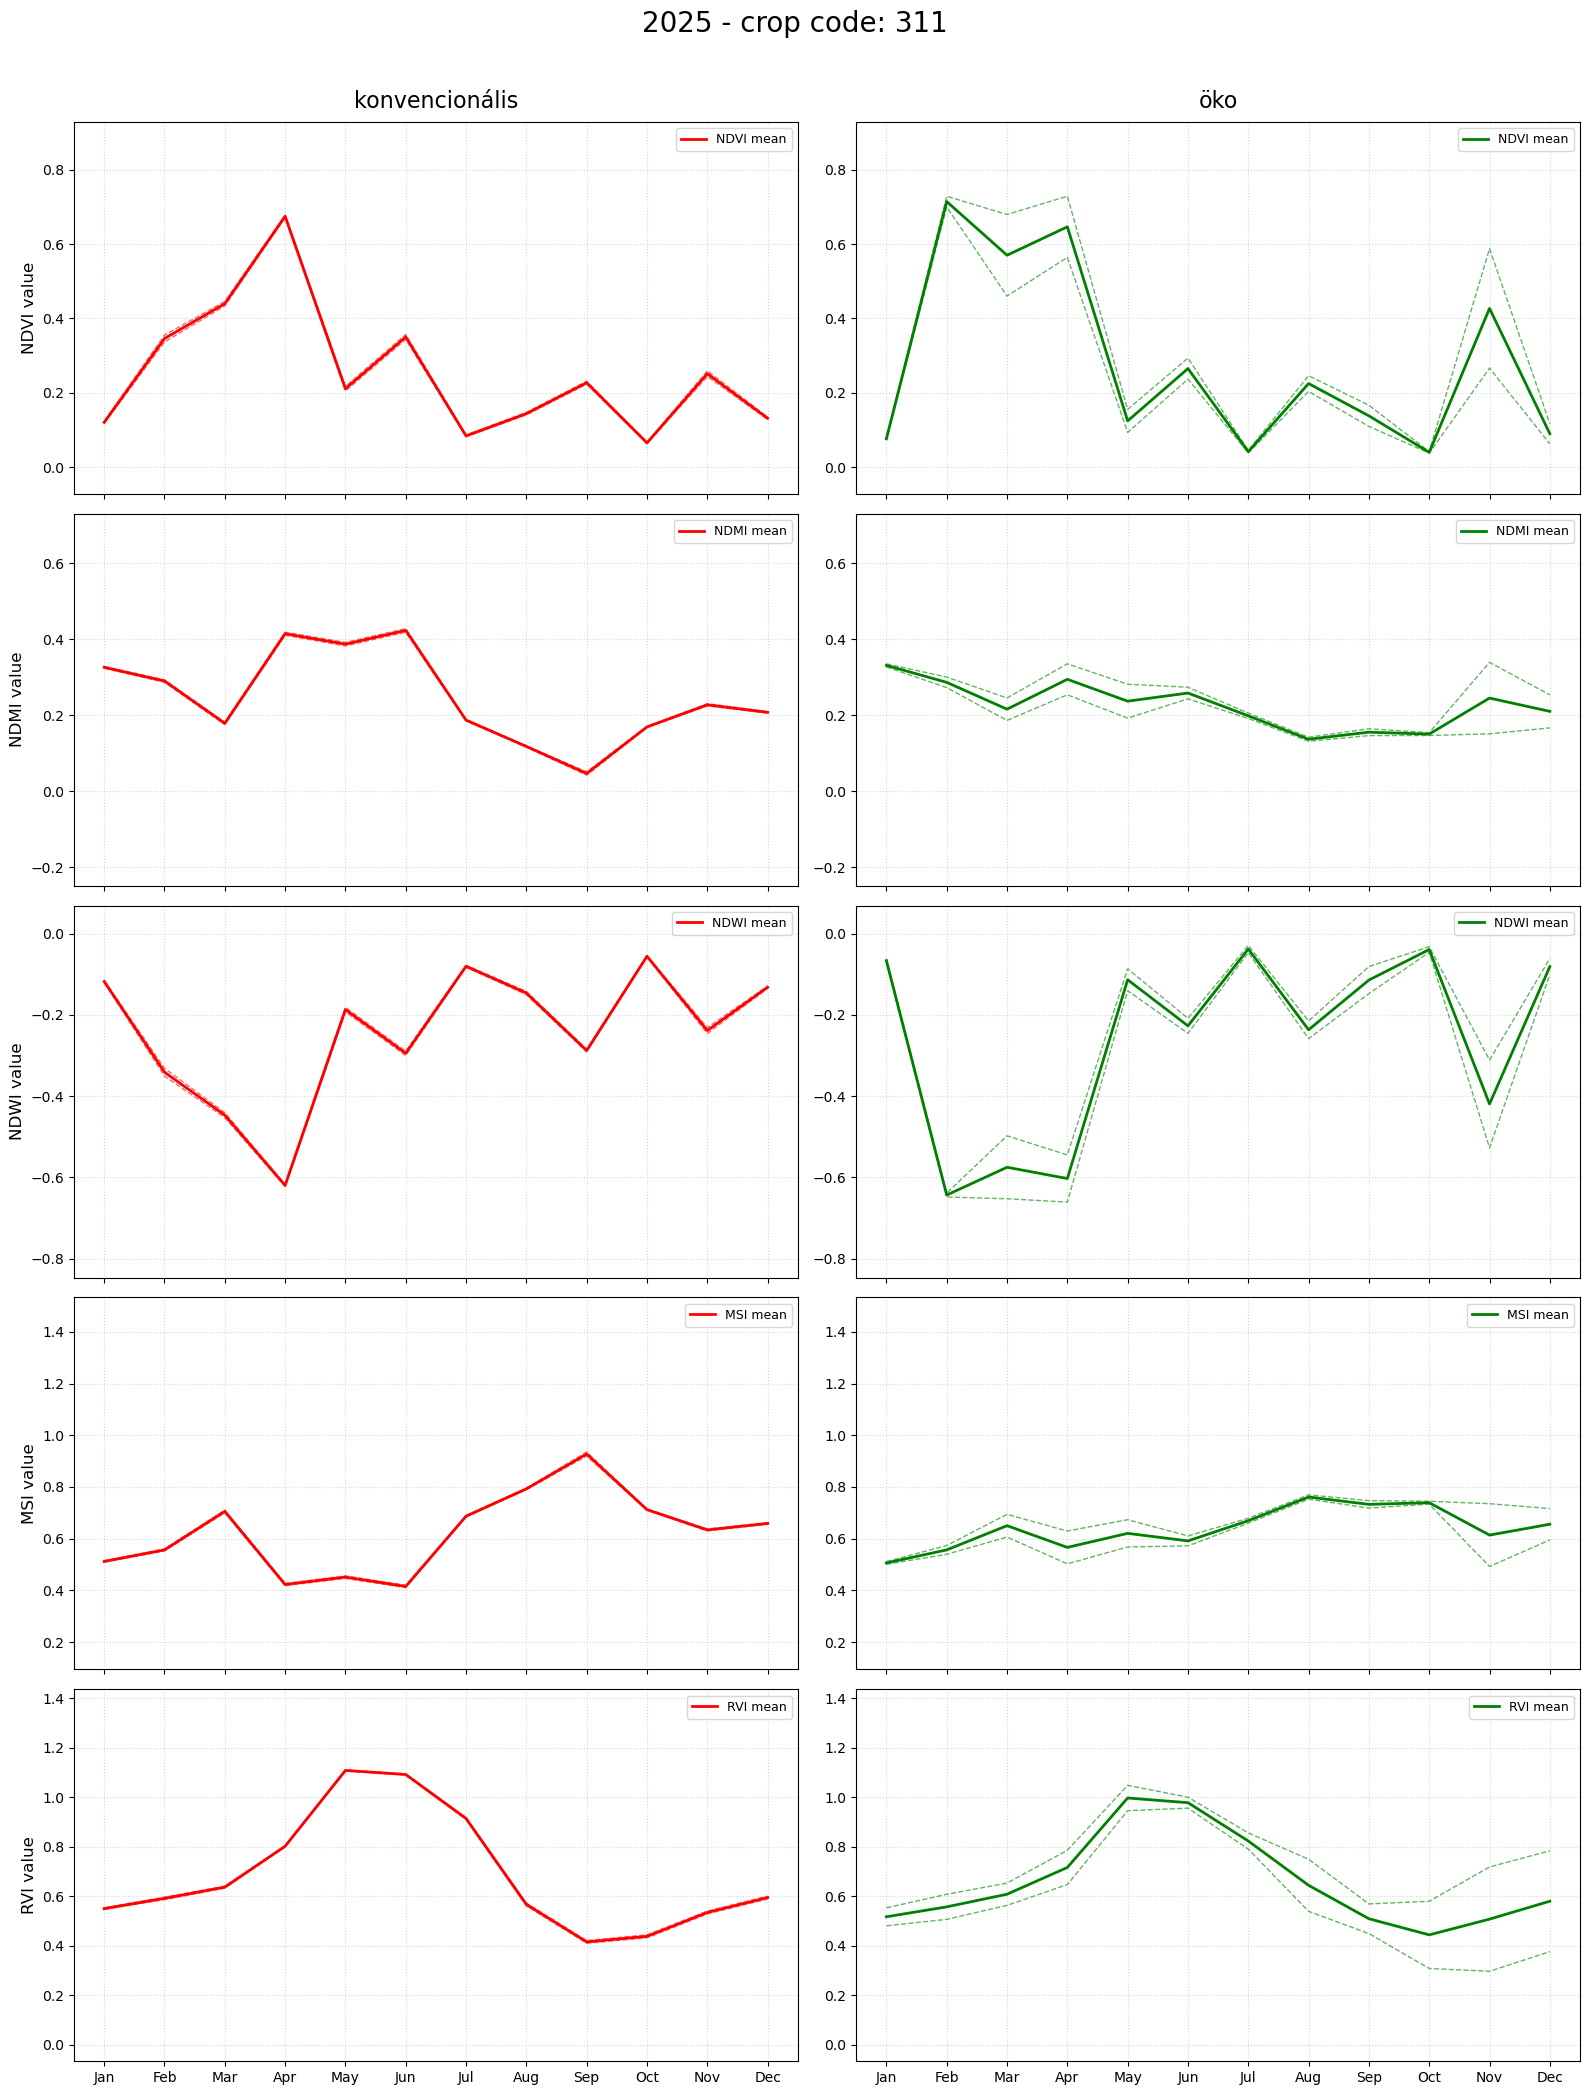

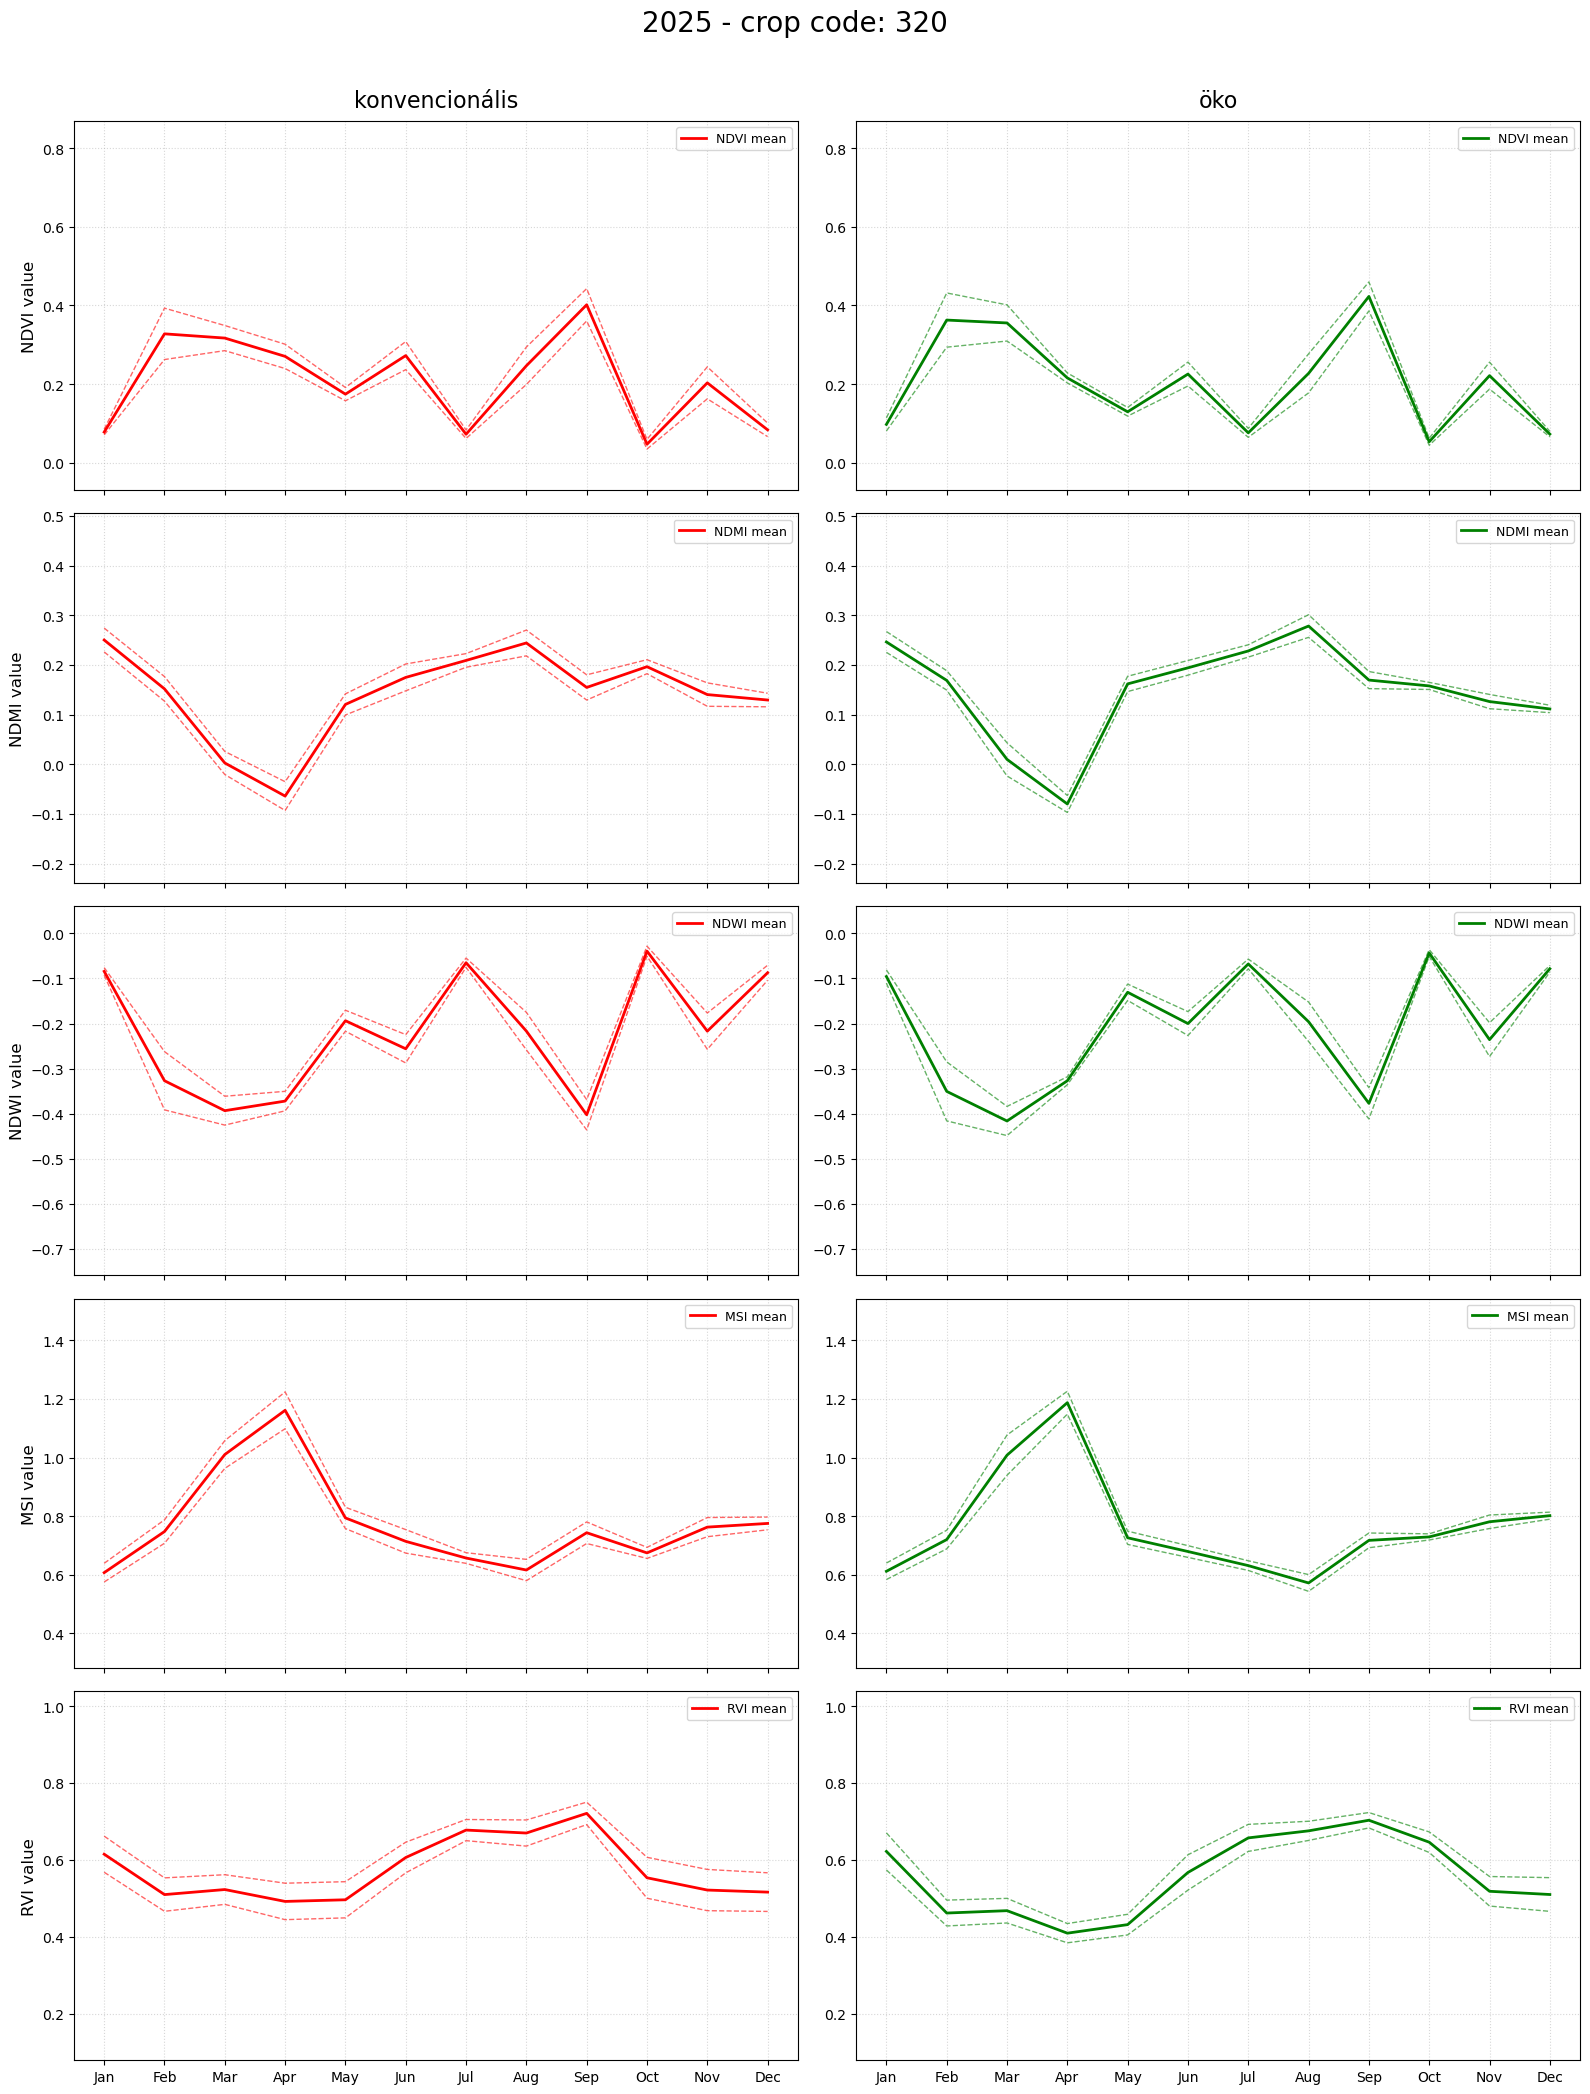

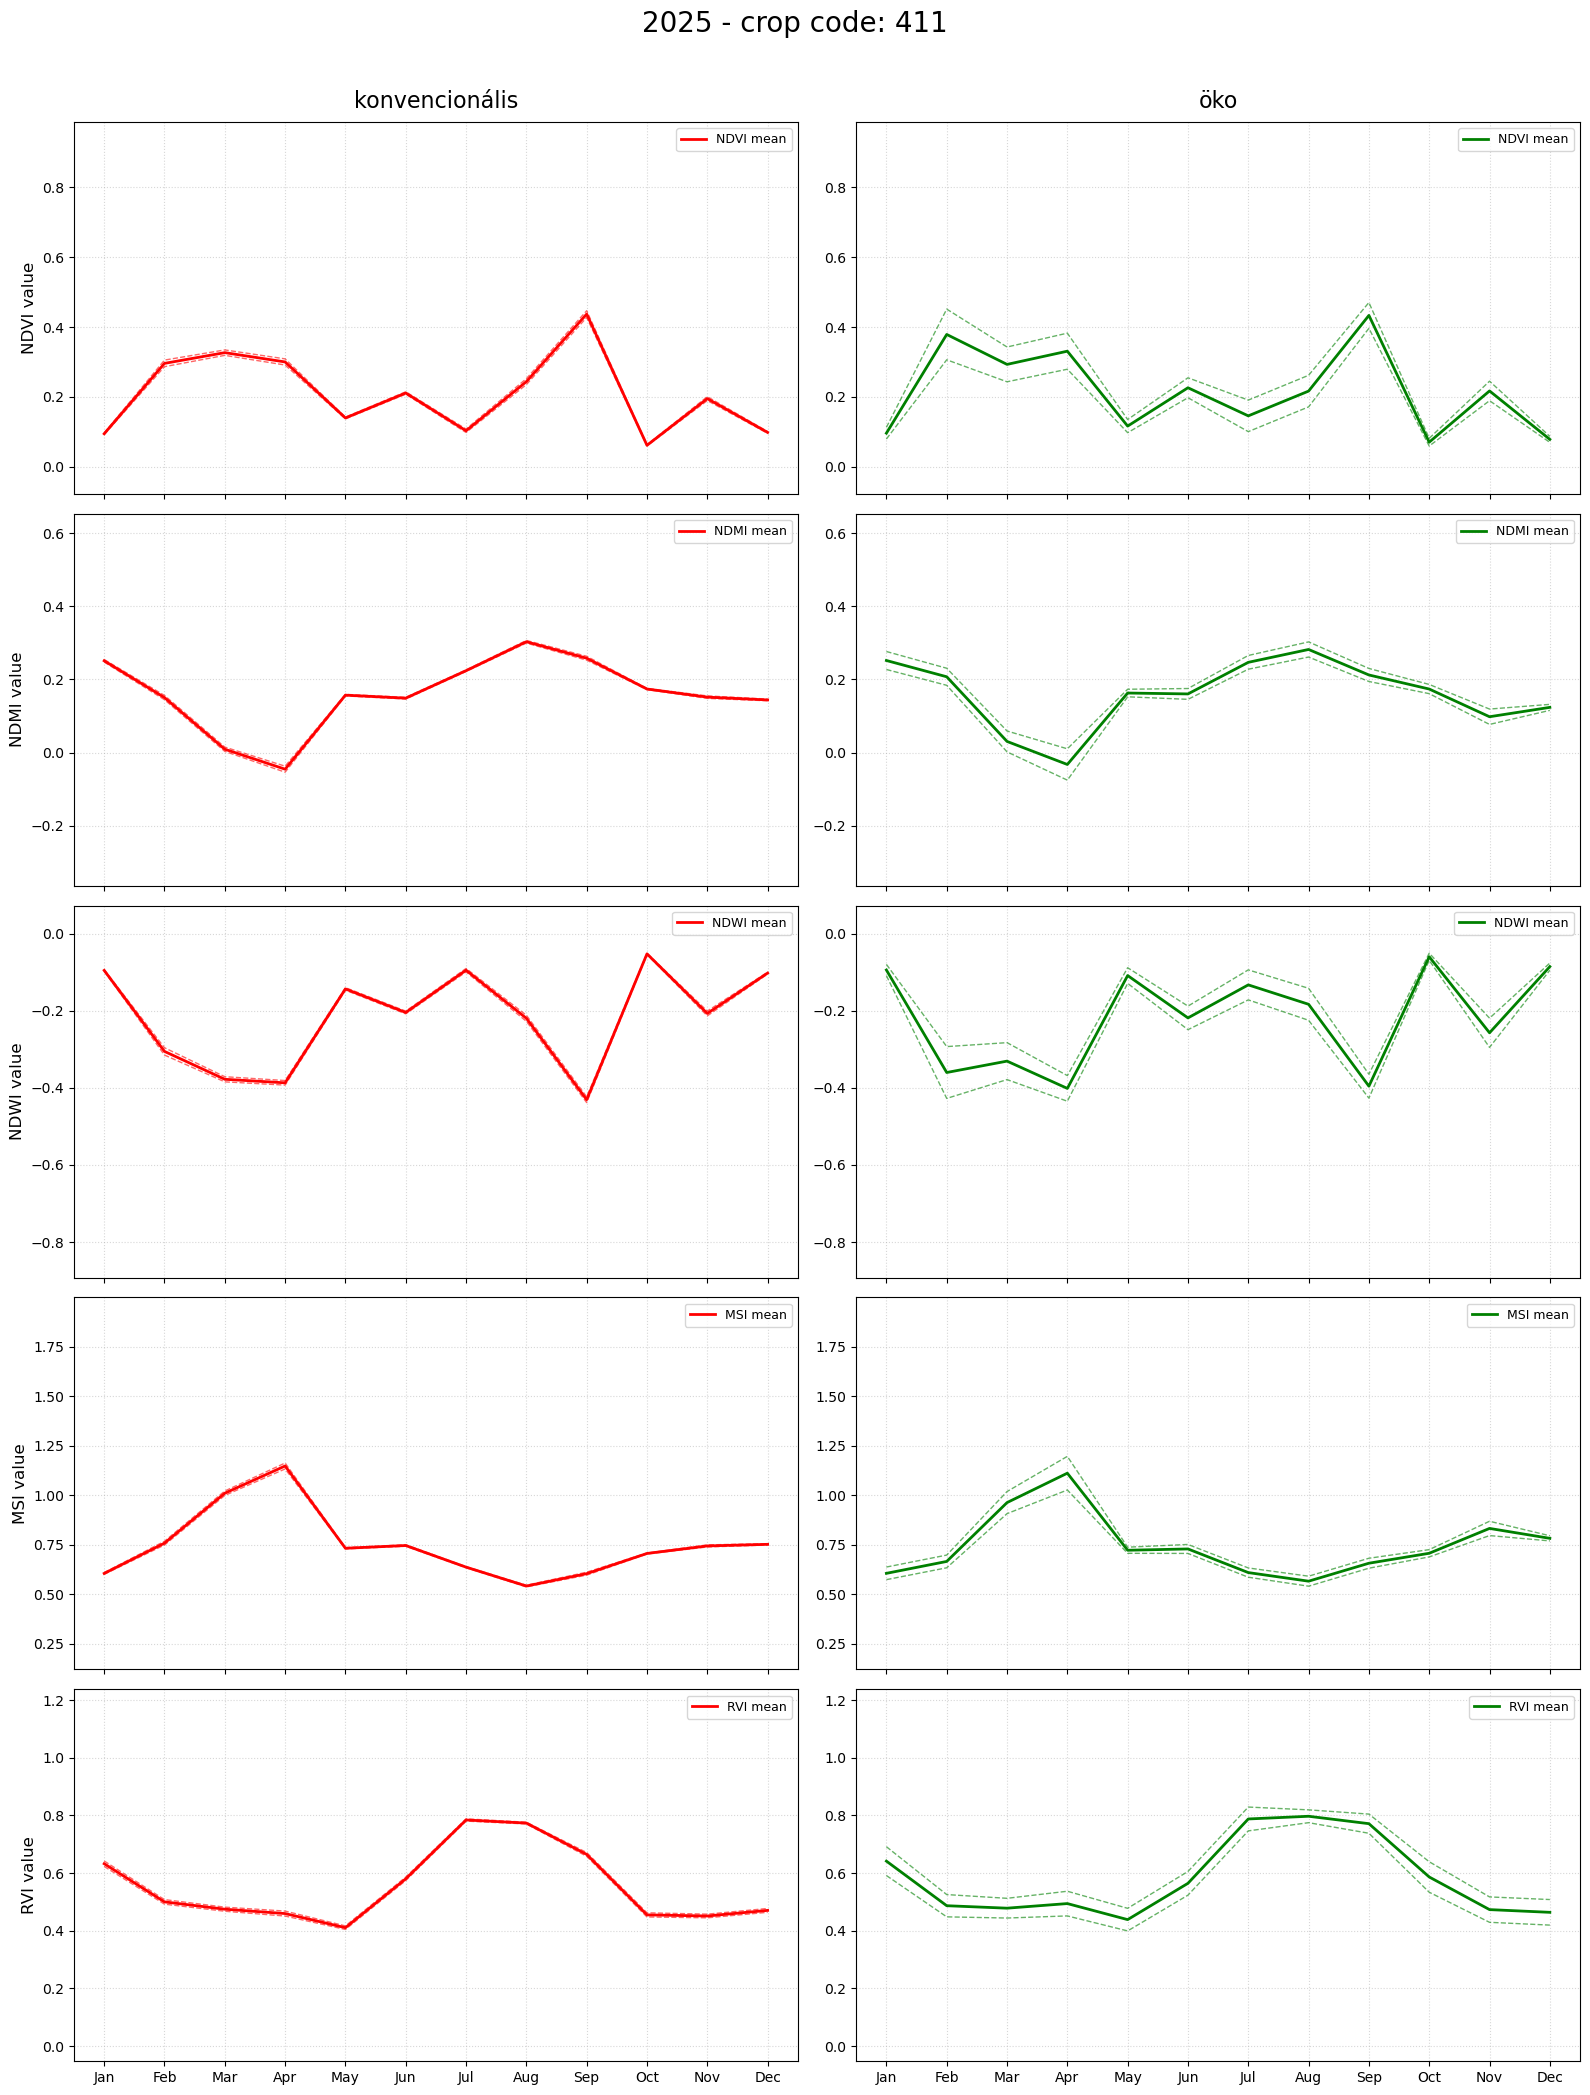

In [7]:
# confidence interval instead of stdev

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

df_path = r'C:\Users\ngarenza\NEW\script\monthly\sar-fixed\mecklenburg_2025_analysis_new.csv'
df = pd.read_csv(df_path)

df['nc'] = df['nc'].astype(float).astype(int)

oko_codes = set(df[df['öko'] == 'öko']['nc'].unique())
conv_codes = set(df[df['öko'] == 'konvencionális']['nc'].unique())
mutual_codes = sorted(list(oko_codes.intersection(conv_codes)))

def plot_graph(df, crop_code):
    crop_df = df[df['nc'] == crop_code].copy()
    
    indices = ['NDVI', 'NDMI', 'NDWI', 'MSI', 'RVI']
    types = ['konvencionális', 'öko']
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 22), sharex=True)
    
    fig.suptitle(f'2025 - crop code: {crop_code}', 
                 fontsize=20, y=0.98, fontweight='regular')

    for r, idx in enumerate(indices):
        row_min = crop_df[idx].min()
        row_max = crop_df[idx].max()
        padding = (row_max - row_min) * 0.1 if row_max != row_min else 0.1

        for c, t in enumerate(types):
            ax = axes[r, c]
            line_color = 'red' if t == 'konvencionális' else 'green'
            subset = crop_df[crop_df['öko'] == t].sort_values('month')
            
            if not subset.empty:
                stats = subset.groupby('month')[idx].agg(['mean', 'std', 'count']).reset_index()
                
                stats['ci_margin'] = 1.96 * (stats['std'] / np.sqrt(stats['count']))
                
                ax.plot(stats['month'], stats['mean'], color=line_color, 
                        linewidth=2, label=f'{idx} mean')
                
                ax.plot(stats['month'], stats['mean'] + stats['ci_margin'], 
                        color=line_color, linestyle='--', alpha=0.6, linewidth=1)
                ax.plot(stats['month'], stats['mean'] - stats['ci_margin'], 
                        color=line_color, linestyle='--', alpha=0.6, linewidth=1)
            
            ax.set_ylim(row_min - padding, row_max + padding)
            ax.set_xlim(0.5, 12.5)
            ax.set_xticks(range(1, 13))
            ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
            ax.grid(True, linestyle=':', alpha=0.5)
            
            if r == 0:
                ax.set_title(t, fontsize=16, fontweight='regular', pad=10)
            if c == 0:
                ax.set_ylabel(f"{idx} value", fontsize=12, fontweight='regular')
            
            ax.legend(loc='upper right', fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) 

    output_path = r'C:\Users\ngarenza\NEW\script\monthly\sar-fixed\graphs\mecklenburg-2025'
    save_path = os.path.join(output_path, f'code_{crop_code}_2024.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

for code in mutual_codes:
    plot_graph(df, code)

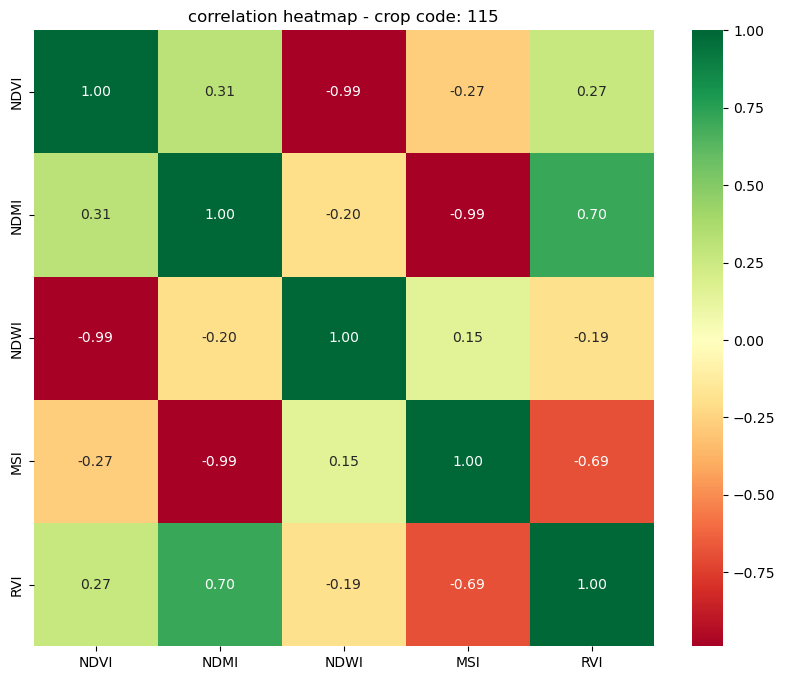

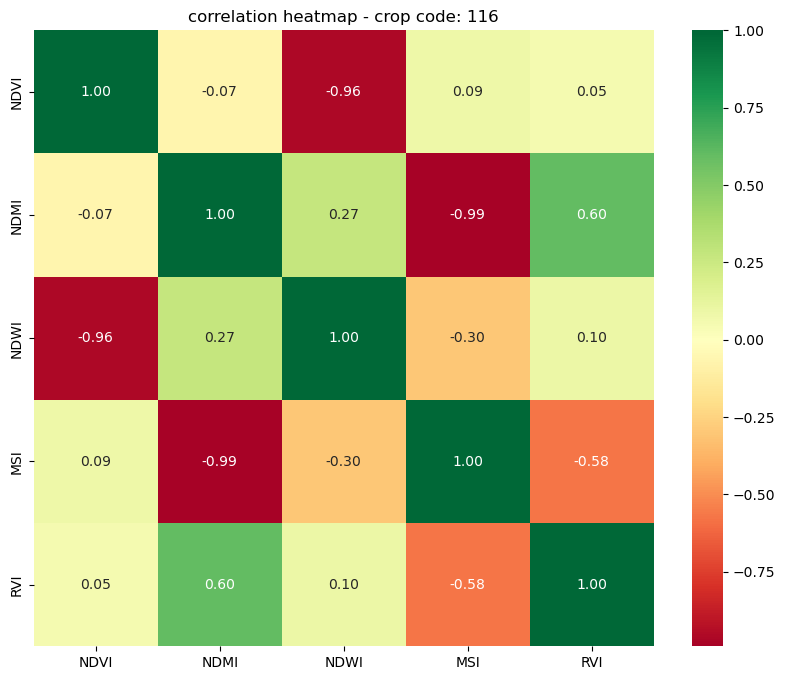

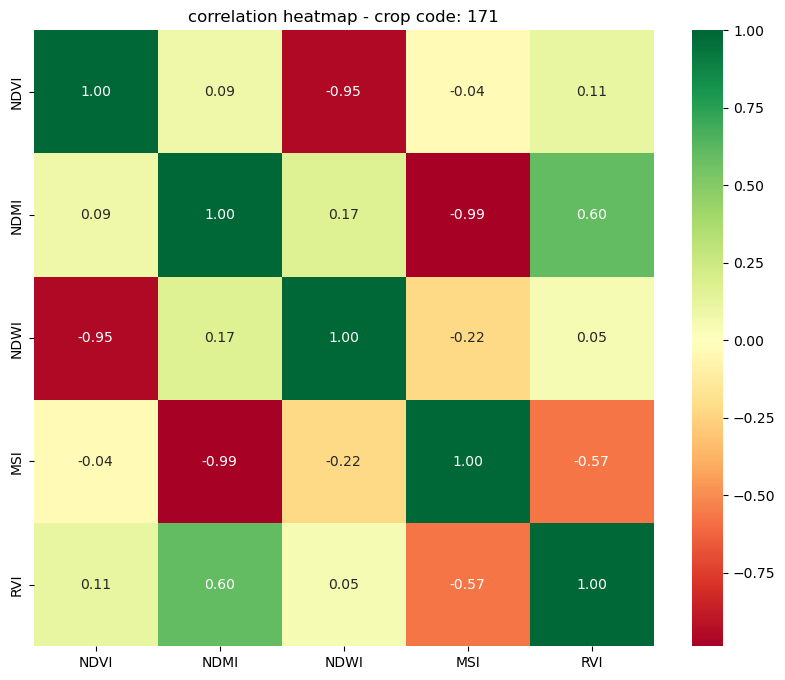

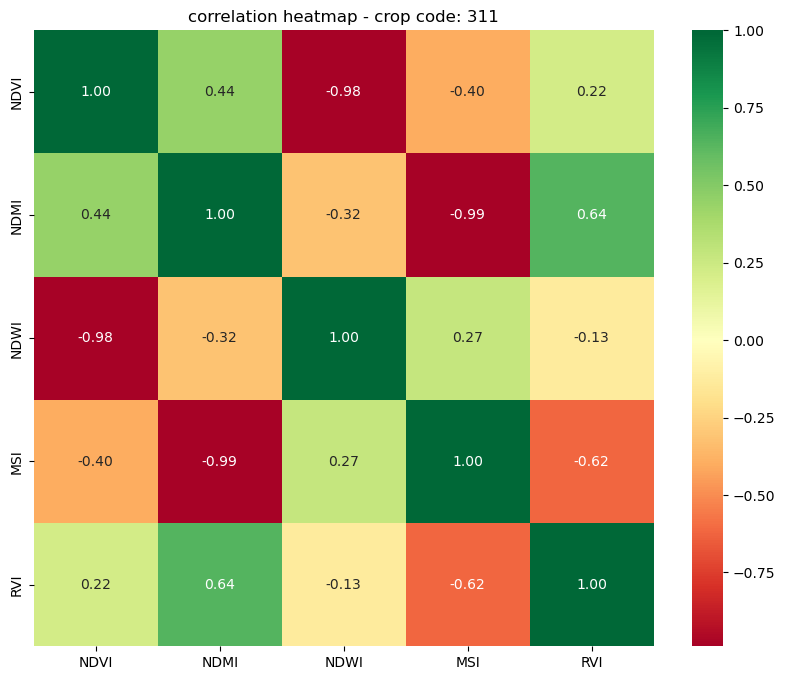

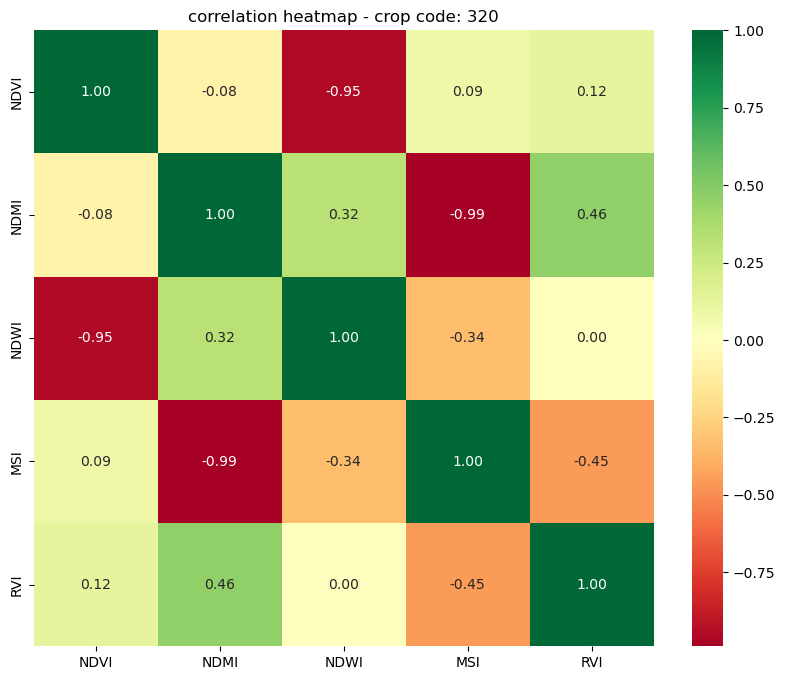

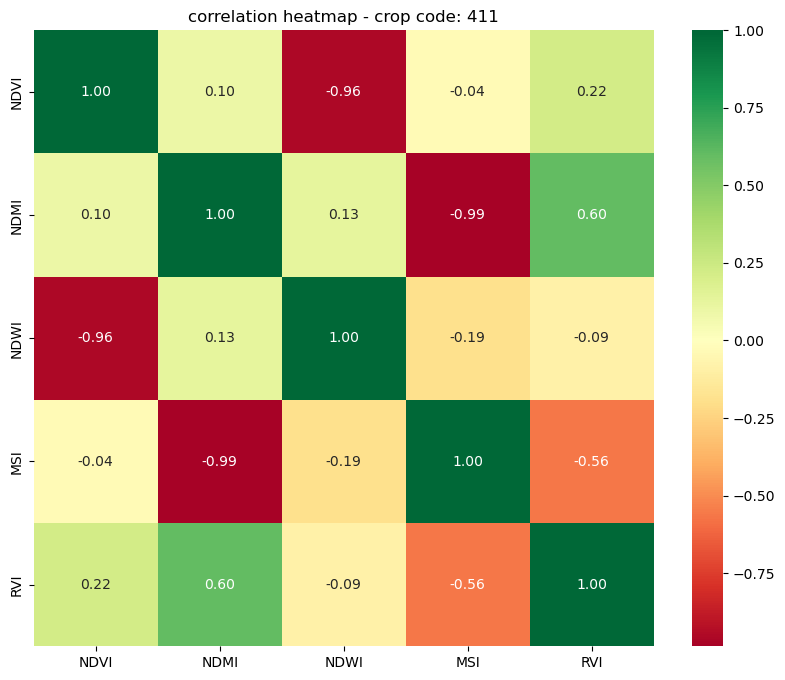

In [24]:
def plot_correlation_heatmap(df, crop_code):
    crop_df = df[df['nc'] == crop_code][['NDVI', 'NDMI', 'NDWI', 'MSI', 'RVI']]

    corr = crop_df.corr()
    
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
    plt.title(f'correlation heatmap - crop code: {crop_code}')
    plt.show()

for code in mutual_codes:
    plot_correlation_heatmap(df, code)

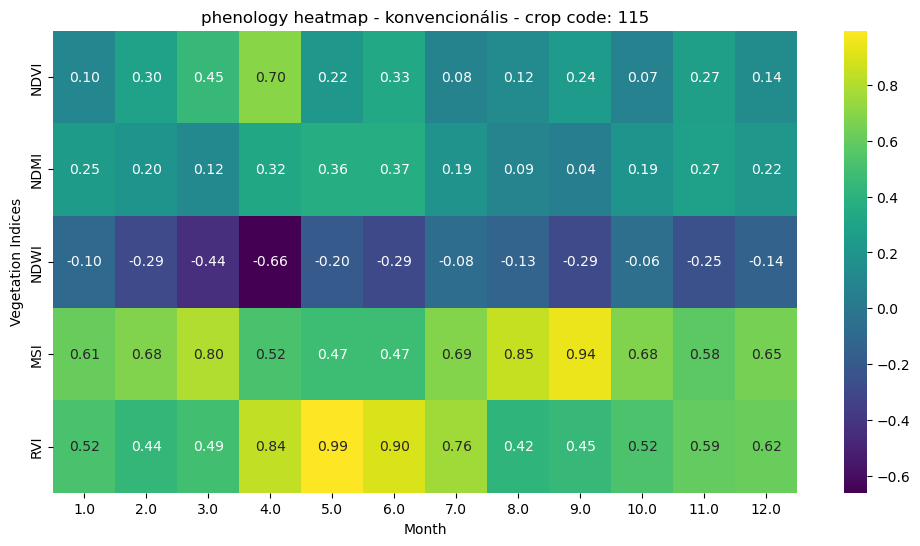

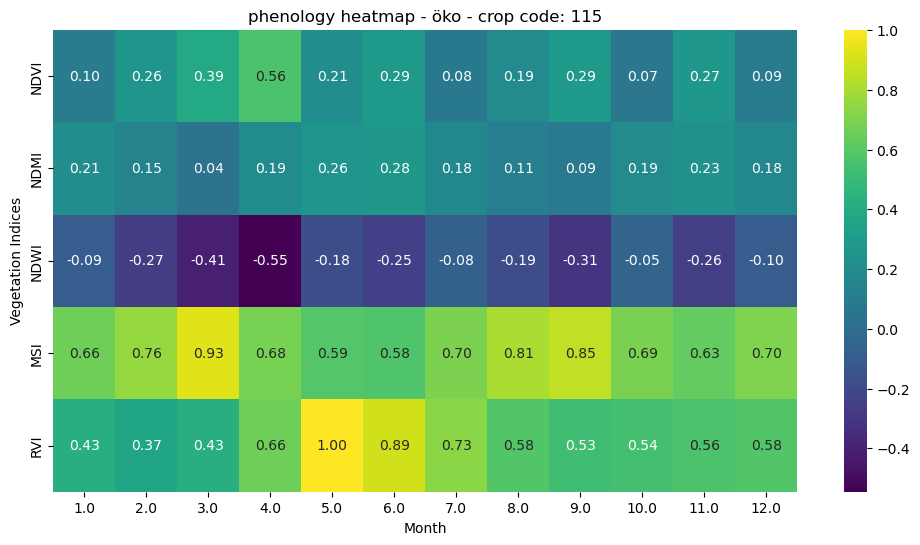

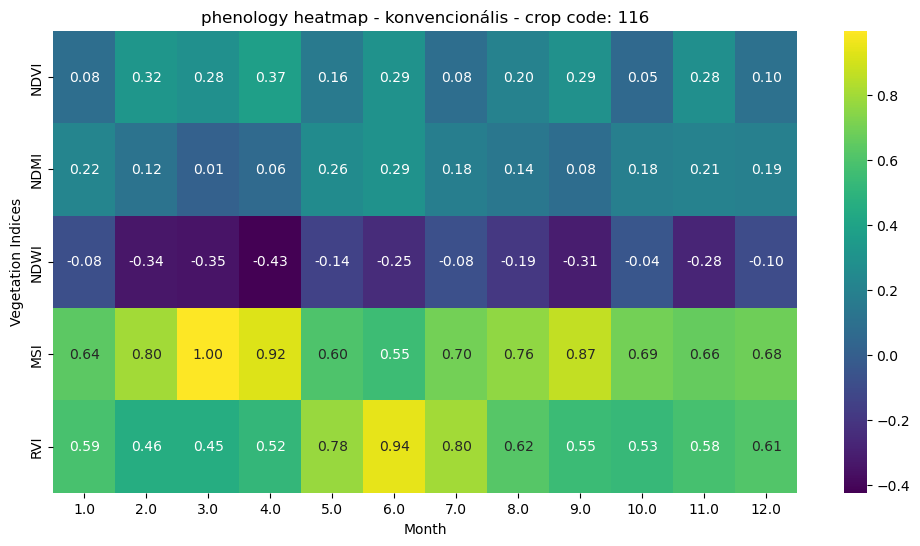

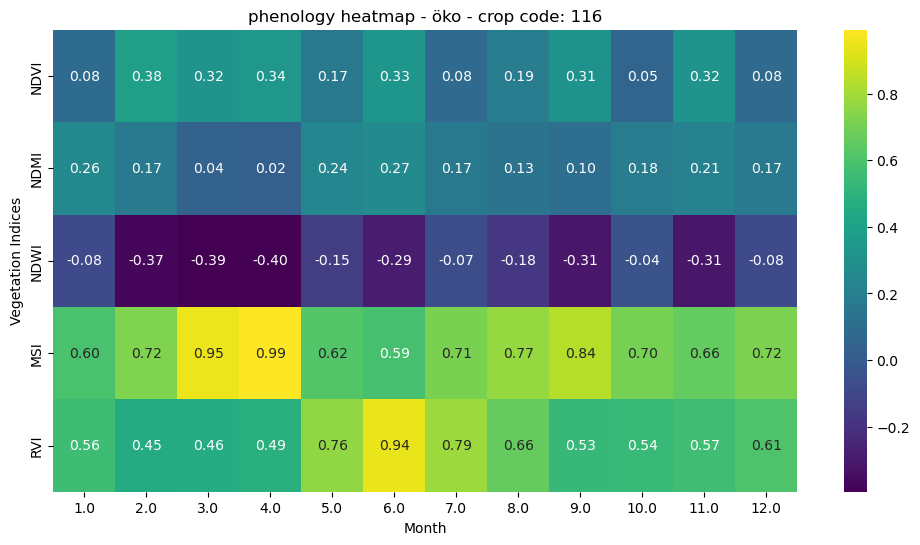

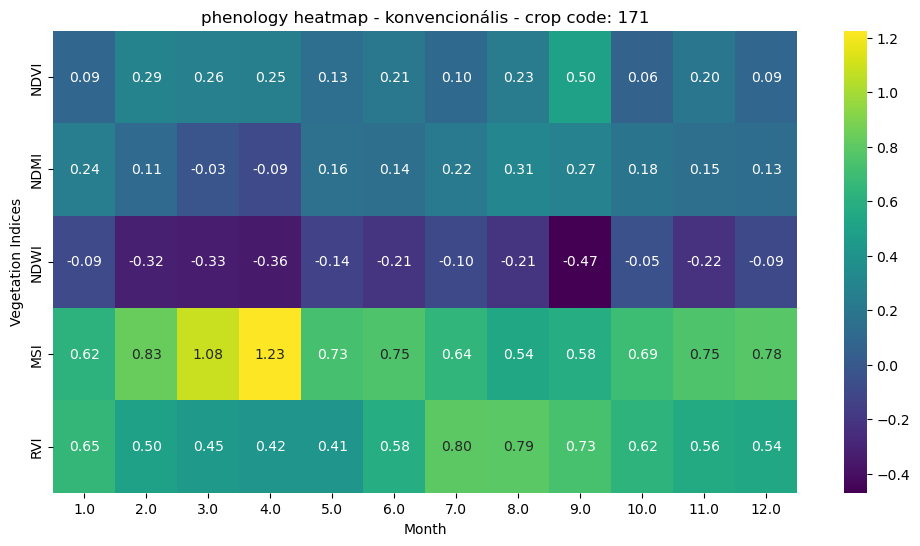

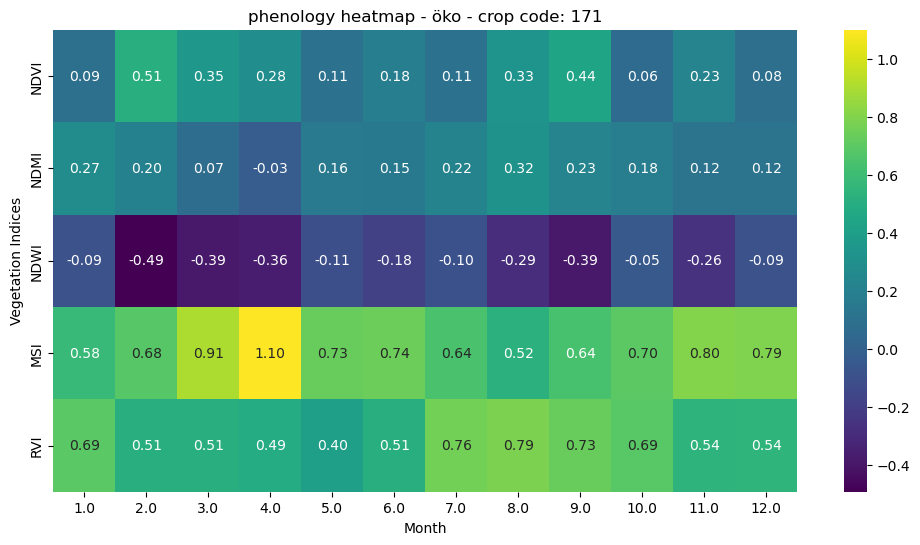

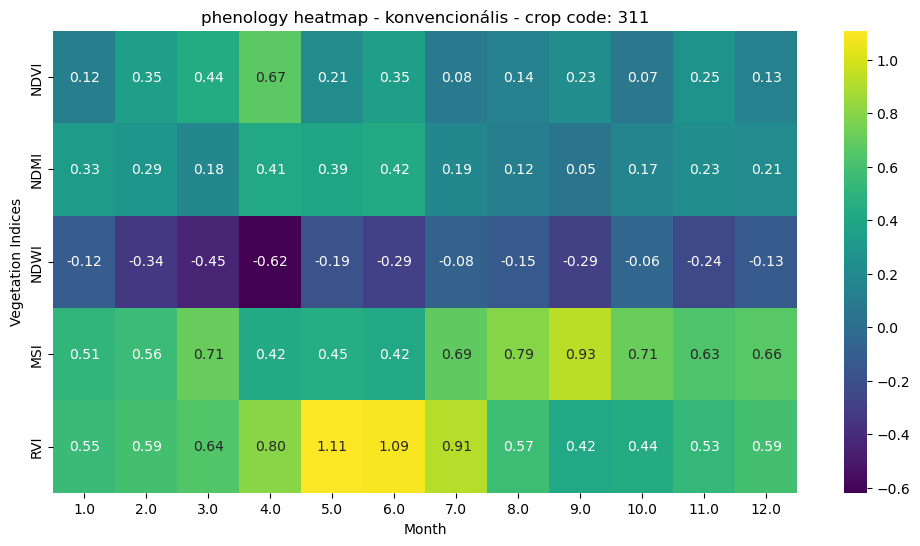

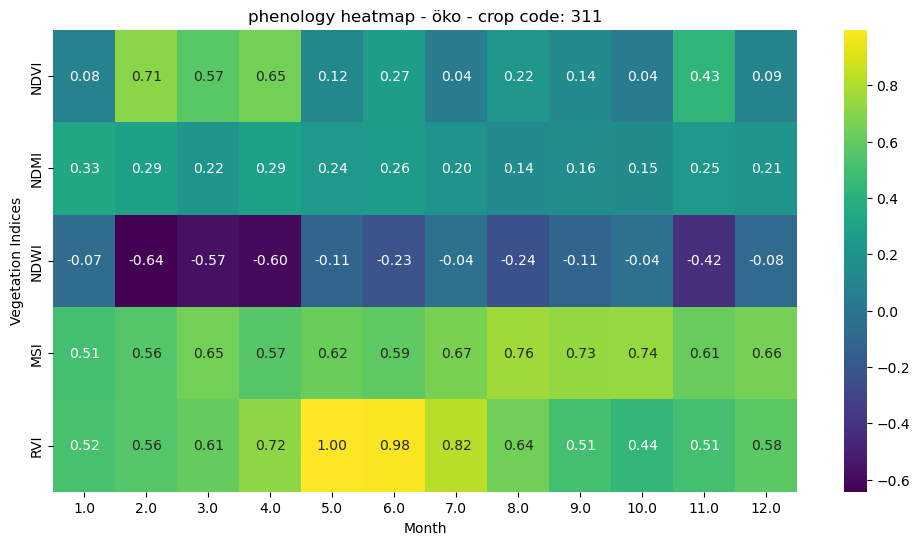

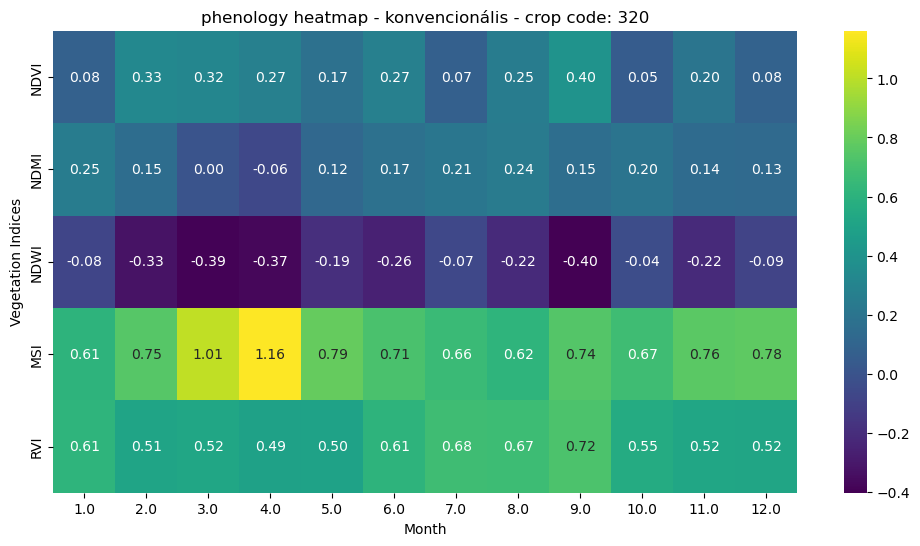

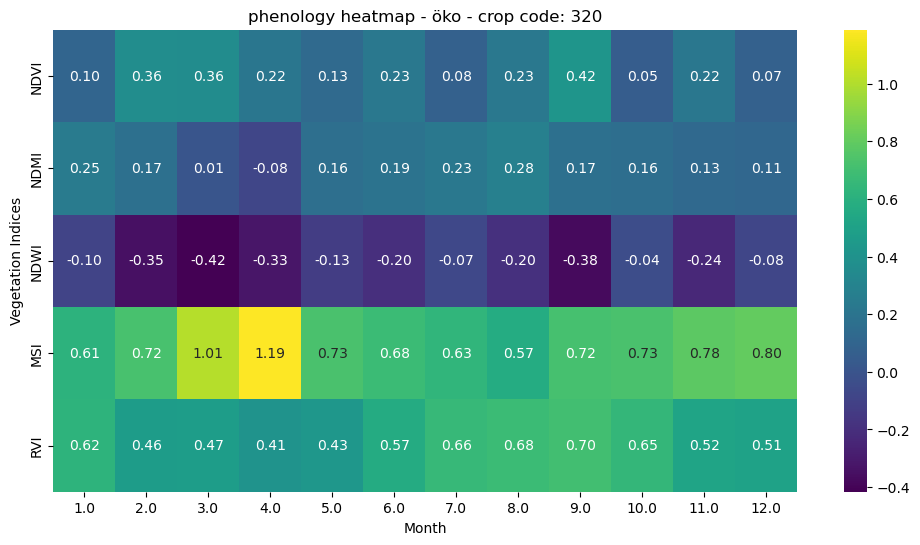

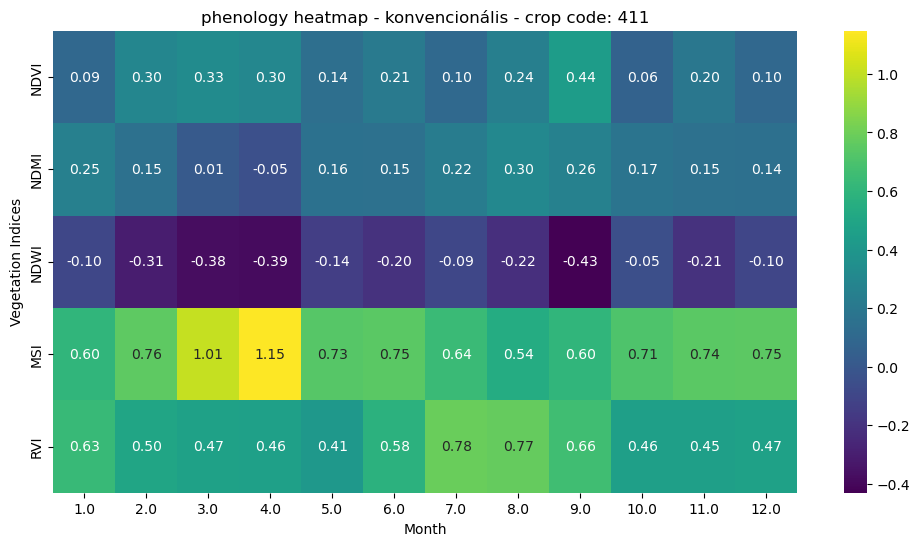

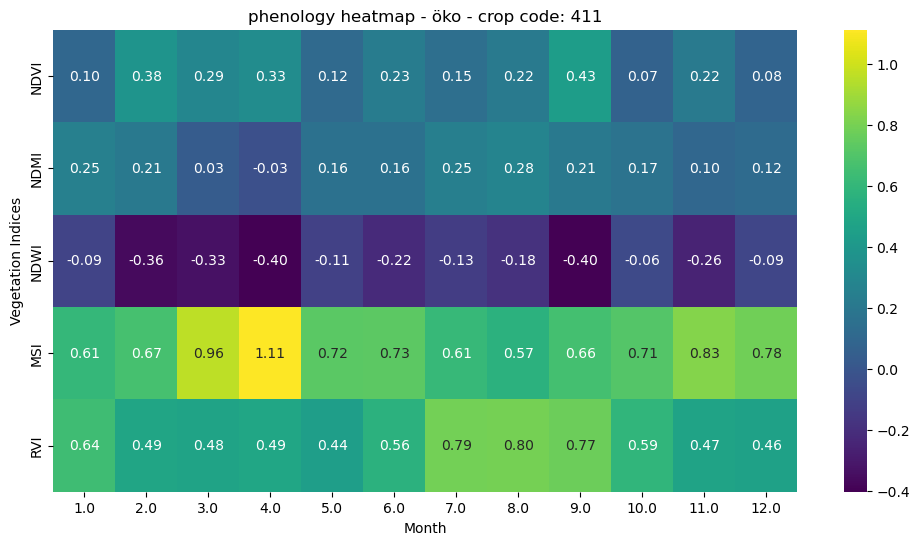

In [23]:
def plot_phenology_heatmap(df, crop_nc, farming):
    subset = df[(df['nc'] == crop_nc) & (df['öko'] == farming)]
    
    indices = ['NDVI', 'NDMI', 'NDWI', 'MSI', 'RVI']
    pivot_df = subset.groupby('month')[indices].mean().T
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, cmap='viridis', annot=True, fmt=".2f")
    plt.title(f'phenology heatmap - {farming} - crop code: {crop_nc}')
    plt.xlabel('Month')
    plt.ylabel('Vegetation Indices')
    plt.show()

types = ['konvencionális', 'öko']

for code in mutual_codes:
    for t in types:
        plot_phenology_heatmap(df, code, t)